<a href="https://colab.research.google.com/github/shivapaliwal/voiolence_alert_system/blob/main/violence_detect_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Loading Dataset**


In [ ]:
!pip install kaggle


In [ ]:
from google.colab import files
files.upload()  # Use this to upload the kaggle.json file


Saving kaggle (1).json to kaggle (1).json


{'kaggle (1).json': b'{"username":"shivangpaliwal","key":"fdfda73d4b7c2ae8b09dc65bfb7184c2"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle(1).json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle(1).json


/bin/bash: -c: line 1: syntax error near unexpected token `('
/bin/bash: -c: line 1: `cp kaggle(1).json ~/.kaggle/'
/bin/bash: -c: line 1: syntax error near unexpected token `('
/bin/bash: -c: line 1: `chmod 600 ~/.kaggle/kaggle(1).json'


In [ ]:
!kaggle datasets download -d mohamedmustafa/real-life-violence-situations-dataset


Dataset URL: https://www.kaggle.com/datasets/mohamedmustafa/real-life-violence-situations-dataset
License(s): copyright-authors
100% 3.57G/3.58G [00:13<00:00, 291MB/s]
100% 3.58G/3.58G [00:13<00:00, 276MB/s]


In [ ]:
!unzip real-life-violence-situations-dataset.zip -d /content


Archive:  real-life-violence-situations-dataset.zip
  inflating: /content/Real Life Violence Dataset/NonViolence/NV_1.mp4  
  inflating: /content/Real Life Violence Dataset/NonViolence/NV_10.mp4  
  inflating: /content/Real Life Violence Dataset/NonViolence/NV_100.mp4  
  inflating: /content/Real Life Violence Dataset/NonViolence/NV_1000.mp4  
  inflating: /content/Real Life Violence Dataset/NonViolence/NV_101.mp4  
  inflating: /content/Real Life Violence Dataset/NonViolence/NV_102.mp4  
  inflating: /content/Real Life Violence Dataset/NonViolence/NV_103.mp4  
  inflating: /content/Real Life Violence Dataset/NonViolence/NV_104.mp4  
  inflating: /content/Real Life Violence Dataset/NonViolence/NV_105.mp4  
  inflating: /content/Real Life Violence Dataset/NonViolence/NV_106.mp4  
  inflating: /content/Real Life Violence Dataset/NonViolence/NV_107.mp4  
  inflating: /content/Real Life Violence Dataset/NonViolence/NV_108.mp4  
  inflating: /content/Real Life Violence Dataset/NonViolence/N

# **New Section**

In [ ]:
import os
import platform
from IPython.display import clear_output
print(platform.platform())

def resolve_dir(Dir):
    if not os.path.exists(Dir):
        os.mkdir(Dir)

def reset_path(Dir):
    if not os.path.exists(Dir):
        os.mkdir(Dir)
    else:
        os.system('rm -f {}/*'.format( Dir))

Linux-6.1.85+-x86_64-with-glibc2.35


In [ ]:
import tensorflow as tf
tf.random.set_seed(73)
TPU_INIT = False

if TPU_INIT:
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
        tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

    except ValueError:
        raise BaseException('ERROR: Not connected to a TPU runtime!')
else:
    !nvidia-smi
;
print("Tensorflow version " + tf.__version__)

/bin/bash: line 1: nvidia-smi: command not found
Tensorflow version 2.15.0


In [ ]:
MyDrive = '/kaggle/working'
PROJECT_DIR = './Downloads/violencedataset'

In [ ]:
!pip install imgaug


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 948.0/948.0 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 32.1 MB/s eta 0:00:00


# **Preprocessing**
--GEtting Frames from a video
-- some image augmentations

In [ ]:
import cv2
import os
import imageio
import imgaug.augmenters as iaa
import imgaug as ia

IMG_SIZE = 128
ColorChannels = 3

def video_to_frames(video):
    vidcap = cv2.VideoCapture(video)

    import math
    rate = math.floor(vidcap.get(3))
    count = 0

    ImageFrames = []
    while vidcap.isOpened():
        ID = vidcap.get(1)
        success, image = vidcap.read()

        if success:
            # skipping frames to avoid duplications
            if (ID % 7 == 0):
                flip = iaa.Fliplr(1.0)
                zoom = iaa.Affine(scale=1.3)
                random_brightness = iaa.Multiply((1, 1.3))
                rotate = iaa.Affine(rotate=(-25, 25))

                image_aug = flip(image = image)
                image_aug = random_brightness(image = image_aug)
                image_aug = zoom(image = image_aug)
                image_aug = rotate(image = image_aug)

                rgb_img = cv2.cvtColor(image_aug, cv2.COLOR_BGR2RGB)
                resized = cv2.resize(rgb_img, (IMG_SIZE, IMG_SIZE))
                ImageFrames.append(resized)

            count += 1
        else:
            break

    vidcap.release()

    return ImageFrames

In [ ]:
%%time
from tqdm import tqdm

VideoDataDir =  'Real Life Violence Dataset'
print('we have \n{} Violence videos \n{} NonViolence videos'.format(
              len(os.listdir(VideoDataDir + '/Violence')),
              len(os.listdir(VideoDataDir + '/NonViolence'))))

X_original = []
y_original = []

print('i choose 700 videos out of 2000, cuz of memory issue')
CLASSES = ["NonViolence", "Violence"]
#700 <- 350 + 350

for category in os.listdir(VideoDataDir):
    path = os.path.join(VideoDataDir, category)
    class_num = CLASSES.index(category)
    for i, video in enumerate(tqdm(os.listdir(path)[0:350])):
        frames = video_to_frames(path + '/' + video)
        for j, frame in enumerate(frames):
            X_original.append(frame)
            y_original.append(class_num)

we have 
1000 Violence videos 
1000 NonViolence videos
i choose 700 videos out of 2000, cuz of memory issue


100%|██████████| 350/350 [00:54<00:00,  6.46it/s]

CPU times: user 5min 25s, sys: 1min 27s, total: 6min 52s
Wall time: 1min 59s


In [ ]:
import numpy as np
X_original = np.array(X_original).reshape(-1 , IMG_SIZE * IMG_SIZE * 3)
y_original = np.array(y_original)
len(X_original)

14304

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

stratified_sample = StratifiedShuffleSplit(n_splits=2, test_size=0.3, random_state=73)

for train_index, test_index in stratified_sample.split(X_original, y_original):
    X_train, X_test = X_original[train_index], X_original[test_index]
    y_train, y_test = y_original[train_index], y_original[test_index]

X_train_nn = X_train.reshape(-1, IMG_SIZE, IMG_SIZE, 3) / 255
X_test_nn = X_test.reshape(-1, IMG_SIZE, IMG_SIZE, 3) / 255


# **Training time**

In [ ]:
!pip install imutils
clear_output()

In [ ]:
import cv2
import os
import numpy as np
import pickle
import matplotlib
matplotlib.use("Agg")

from keras.layers import Input
from keras.models import Model
from tensorflow.keras.layers import Dropout, Flatten, Dense

import matplotlib.pyplot as plt

In [ ]:
epochs = 70

from keras import regularizers
kernel_regularizer = regularizers.l2(0.0001)

from keras.applications.mobilenet_v2 import MobileNetV2

def load_layers():
    input_tensor = Input(shape=(IMG_SIZE, IMG_SIZE, ColorChannels))
    baseModel = MobileNetV2(pooling='avg',
                            include_top=False,
                            input_tensor=input_tensor)

    headModel = baseModel.output
    headModel = Dense(1, activation="sigmoid")(headModel)
    model = Model(inputs=baseModel.input, outputs=headModel)

    for layer in baseModel.layers:
        layer.trainable = False

    print("Compiling model...")
    model.compile(loss="binary_crossentropy",
                    optimizer='adam',
                    metrics=["accuracy"])

    return model

if TPU_INIT:
    with tpu_strategy.scope():
        model = load_layers()
else:
    model = load_layers()

model.summary()

9406464/9406464 [==============================] - 0s 0us/step
Compiling model...
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 64, 64, 32)           864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 64, 64, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu 

In [ ]:
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping, ReduceLROnPlateau

patience = 3

start_lr = 0.00001
min_lr = 0.00001
max_lr = 0.00005

batch_size = 4

if TPU_INIT:
    max_lr = max_lr * tpu_strategy.num_replicas_in_sync
    batch_size = batch_size * tpu_strategy.num_replicas_in_sync

rampup_epochs = 5
sustain_epochs = 0
exp_decay = .8

def lrfn(epoch):
    if epoch < rampup_epochs:
        return (max_lr - start_lr)/rampup_epochs * epoch + start_lr
    elif epoch < rampup_epochs + sustain_epochs:
        return max_lr
    else:
        return (max_lr - min_lr) * exp_decay**(epoch-rampup_epochs-sustain_epochs) + min_lr


class myCallback(Callback):
    def on_epoch_end(self, epoch, logs={}):
        if ((logs.get('accuracy')>=0.999)):
            print("\nLimits Reached cancelling training!")
            self.model.stop_training = True

In [ ]:
end_callback = myCallback()

lr_callback = LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=False)

early_stopping = EarlyStopping(
    patience=patience,
    monitor='val_loss',
    mode='min',
    restore_best_weights=True,
    verbose=1,
    min_delta=0.00075
)

PROJECT_DIR = MyDrive + '/RiskDetection'

lr_plat = ReduceLROnPlateau(patience=2, mode='min')

# Remove any existing logs directory
os.system('rm -rf ./logs/')

import datetime
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, write_graph=True, histogram_freq=1)

checkpoint_filepath = 'ModelWeights.weights.h5'  # Ensure it ends with .weights.h5

model_checkpoints = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1,
    save_best_only=True
)

# Define callbacks list
callbacks = [end_callback, lr_callback, model_checkpoints, tensorboard_callback, early_stopping, lr_plat]

# If using TPU, modify the callbacks list as needed
if TPU_INIT:
    callbacks = [end_callback, lr_callback, model_checkpoints, early_stopping, lr_plat]


In [ ]:
print('Training head...')
#model.load_weights('./Model_Weights.h5')

history = model.fit(X_train_nn ,y_train, epochs=epochs,
                        callbacks=callbacks,
                        validation_data = (X_test_nn, y_test),
                        batch_size=batch_size)

print('\nRestoring best Weights for MobileNetV2')
model.load_weights(checkpoint_filepath)

Training head...
Epoch 1/70
2503/2503 [==============================] - ETA: 0s - loss: 0.7769 - accuracy: 0.5745
Epoch 1: val_loss improved from inf to 0.66319, saving model to ModelWeights.weights.h5
2503/2503 [==============================] - 87s 34ms/step - loss: 0.7769 - accuracy: 0.5745 - val_loss: 0.6632 - val_accuracy: 0.6421 - lr: 1.0000e-05
Epoch 2/70
2501/2503 [============================>.] - ETA: 0s - loss: 0.5725 - accuracy: 0.7022
Epoch 2: val_loss improved from 0.66319 to 0.49422, saving model to ModelWeights.weights.h5
2503/2503 [==============================] - 82s 33ms/step - loss: 0.5725 - accuracy: 0.7024 - val_loss: 0.4942 - val_accuracy: 0.7598 - lr: 1.8000e-05
Epoch 3/70
2502/2503 [============================>.] - ETA: 0s - loss: 0.4437 - accuracy: 0.7928
Epoch 3: val_loss improved from 0.49422 to 0.40103, saving model to ModelWeights.weights.h5
2503/2503 [==============================] - 81s 32ms/step - loss: 0.4436 - accuracy: 0.7928 - val_loss: 0.4010 -

In [ ]:
%matplotlib inline

def print_graph(item, index, history):
    plt.figure()
    train_values = history.history[item][0:index]
    plt.plot(train_values)
    test_values = history.history['val_' + item][0:index]
    plt.plot(test_values)
    plt.legend(['training','validation'])
    plt.title('Training and validation '+ item)
    plt.xlabel('epoch')
    plt.show()
    plot = '{}.png'.format(item)
    plt.savefig(plot)


def get_best_epoch(test_loss, history):
    for key, item in enumerate(history.history.items()):
        (name, arr) = item
        if name == 'val_loss':
            for i in range(len(arr)):
                if round(test_loss, 2) == round(arr[i], 2):
                    return i

def model_summary(model, history):
    print('---'*30)
    test_loss, test_accuracy = model.evaluate(X_test_nn, y_test, verbose=0)

    if history:
        index = get_best_epoch(test_loss, history)
        print('Best Epochs: ', index)

        train_accuracy = history.history['accuracy'][index]
        train_loss = history.history['loss'][index]

        print('Accuracy on train:',train_accuracy,'\tLoss on train:',train_loss)
        print('Accuracy on test:',test_accuracy,'\tLoss on test:',test_loss)
        print_graph('loss', index, history)
        print_graph('accuracy', index, history)
        print('---'*30)

------------------------------------------------------------------------------------------
Best Epochs:  54
Accuracy on train: 0.9237914681434631 	Loss on train: 0.19756166636943817
Accuracy on test: 0.9168220162391663 	Loss on test: 0.2188597172498703


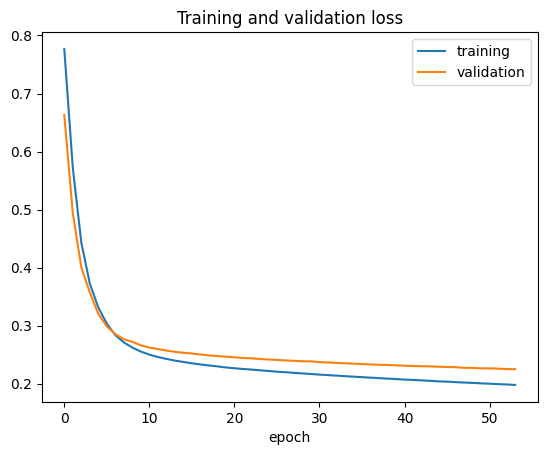

<Figure size 640x480 with 0 Axes>

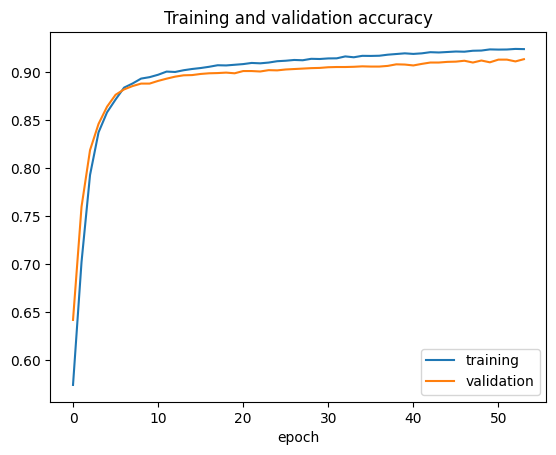

------------------------------------------------------------------------------------------


<Figure size 640x480 with 0 Axes>

In [ ]:
model_summary(model, history)

In [ ]:
# evaluate the network
print("Evaluating network...")
predictions = model.predict(X_test_nn)
preds = predictions > 0.5

Evaluating network...
135/135 [==============================] - 10s 69ms/step


> Correct Predictions: 3935
> Wrong Predictions: 357


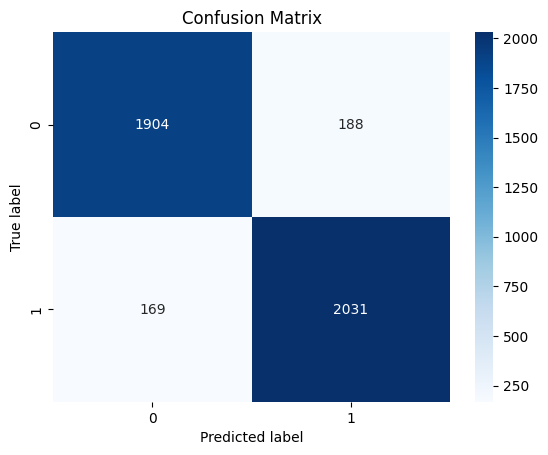

              precision    recall  f1-score   support

 NonViolence       0.92      0.91      0.91      2092
    Violence       0.92      0.92      0.92      2200

    accuracy                           0.92      4292
   macro avg       0.92      0.92      0.92      4292
weighted avg       0.92      0.92      0.92      4292



In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, classification_report, confusion_matrix

# Assuming `y_test` are the true labels and `preds` are your model's predicted labels

# Calculate the confusion matrix
corr_pred = confusion_matrix(y_test, preds)

# Calculate the number of correct and incorrect predictions
n_correct = int(corr_pred[0][0] + corr_pred[1][1])
print('> Correct Predictions:', n_correct)
n_wrongs = int(corr_pred[0][1] + corr_pred[1][0])
print('> Wrong Predictions:', n_wrongs)

# Plot the confusion matrix using Seaborn
sns.heatmap(corr_pred, annot=True, fmt="d", cmap="Blues")
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Print the classification report
print(classification_report(y_test, preds, target_names=["NonViolence", "Violence"]))


In [ ]:
args_model = "violenceDetectSIH_2.h5"
model.save(args_model)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
args_model = "violenceDetectSIH_2.keras"  # Updated file extension
model.save(args_model)


In [ ]:
args_model = "violenceDetectSIH_2.h5"
model.save(args_model)

In [ ]:
from google.colab import files

# Download the model file
files.download(args_model)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
